# Decision Trees Draft

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Read in data
df_train = pd.read_csv('./../../../large_data/03-classification-model-data/Twitter/df_train.tsv', sep='\t')
df_test = pd.read_csv('./../../../large_data/03-classification-model-data/Twitter/df_test.tsv', sep='\t')

bow_train = np.array(pd.read_csv('./../../../large_data/03-classification-model-data/Twitter/bow_train.csv'))
bow_test = np.array(pd.read_csv('./../../../large_data/03-classification-model-data/Twitter/bow_test.csv'))

vocab_train = json.load(open('./../../../large_data/03-classification-model-data/Twitter/vocab_train.json'))

Perform balance check

In [2]:
balance_check = pd.DataFrame(
    [
        df_train['labels'].value_counts(sort=True).to_list(),
        df_train['labels'].value_counts(sort=True, normalize=True).to_list()
    ], 
    index=['Count', 'Percentage'], columns=['Opinion', 'News']
).T

balance_check

,Count,Percentage
Opinion,16944.0,0.537495
News,14580.0,0.462505


## Random Classifier for Baseline

In [3]:
# Randomize labels
labels_rand = np.array(df_train['labels'].copy())
np.random.shuffle(labels_rand)

# Build model

In [5]:
model_rand = tree.DecisionTreeClassifier()
model_rand = model_rand.fit(bow_train, labels_rand)

yp_train_rand = model_rand.predict(bow_train)
yp_test_rand = model_rand.predict(bow_test)

target_names = ['News', 'Opinion']

# Calculate the confusion matrix and classification report for the train and test data. 
cm_train = confusion_matrix(labels_rand, yp_train_rand, labels=model_rand.classes_)
cm_test = confusion_matrix(labels_rand, yp_test_rand, labels=model_rand.classes_)

# Save the results in a data frame. 
clf_report_linear_train = classification_report(labels_rand, yp_train_rand, target_names=target_names, output_dict=True)
clf_report_linear_train = pd.DataFrame(clf_report_linear_train).transpose()

clf_report_linear_train


In [ ]:
# Display Confusion Matrix for the test data. Remember to use the ConfusionMatrixDisplay function.

# Plot individual confusion matrices for website
plt.rcParams.update({'font.size': 40})

fig_baseline, ax_baseline = plt.subplots(figsize=(20, 13))

sns.heatmap(cm_test, annot=True, fmt='g', ax=ax_baseline, vmin=0, vmax=3500, cmap='Greens')

# Specify axis titles
ax_baseline.set_title("Initial Decision Tree Model", fontdict={'fontsize': 50})

# Specify labels and ticks
ax_baseline.set_xlabel('Predicted label')
ax_baseline.set_ylabel('True label')
ax_baseline.xaxis.set_ticklabels(['News', 'Opinion'])
ax_baseline.yaxis.set_ticklabels(['News', 'Opinion'])

plt.savefig('./../../501-project-website/images/dt/cm_init.png')

## Training the model

In [74]:
model = tree.DecisionTreeClassifier(max_depth=5)
model = model.fit(bow_train, df_train['labels'])

Check results

In [75]:
yp_train = model.predict(bow_train)
yp_test = model.predict(bow_test)

target_names = ['News', 'Opinion']

# Calculate the confusion matrix and classification report for the train and test data. 
cm_train = confusion_matrix(df_train['labels'], yp_train, labels=model.classes_)
cm_test = confusion_matrix(df_test['labels'], yp_test, labels=model.classes_)

# Save the results in a data frame. 
clf_report_linear_train = classification_report(df_train['labels'], yp_train, target_names=target_names, output_dict=True)
clf_report_linear_train = pd.DataFrame(clf_report_linear_train).transpose()

clf_report_linear_train


,precision,recall,f1-score,support
News,0.993525,0.999794,0.996650,14580.000000
Opinion,0.999822,0.994393,0.997100,16944.000000
accuracy,0.996891,0.996891,0.996891,0.996891
macro avg,0.996674,0.997094,0.996875,31524.000000
weighted avg,0.996910,0.996891,0.996892,31524.000000


In [76]:
clf_report_linear_test = classification_report(df_test['labels'], yp_test, target_names=target_names, output_dict=True)
clf_report_linear_test = pd.DataFrame(clf_report_linear_test).transpose()

clf_report_linear_test

,precision,recall,f1-score,support
News,0.793345,0.123400,0.213579,3671.000000
Opinion,0.559781,0.971971,0.710417,4210.000000
accuracy,0.576703,0.576703,0.576703,0.576703
macro avg,0.676563,0.547686,0.461998,7881.000000
weighted avg,0.668576,0.576703,0.478988,7881.000000


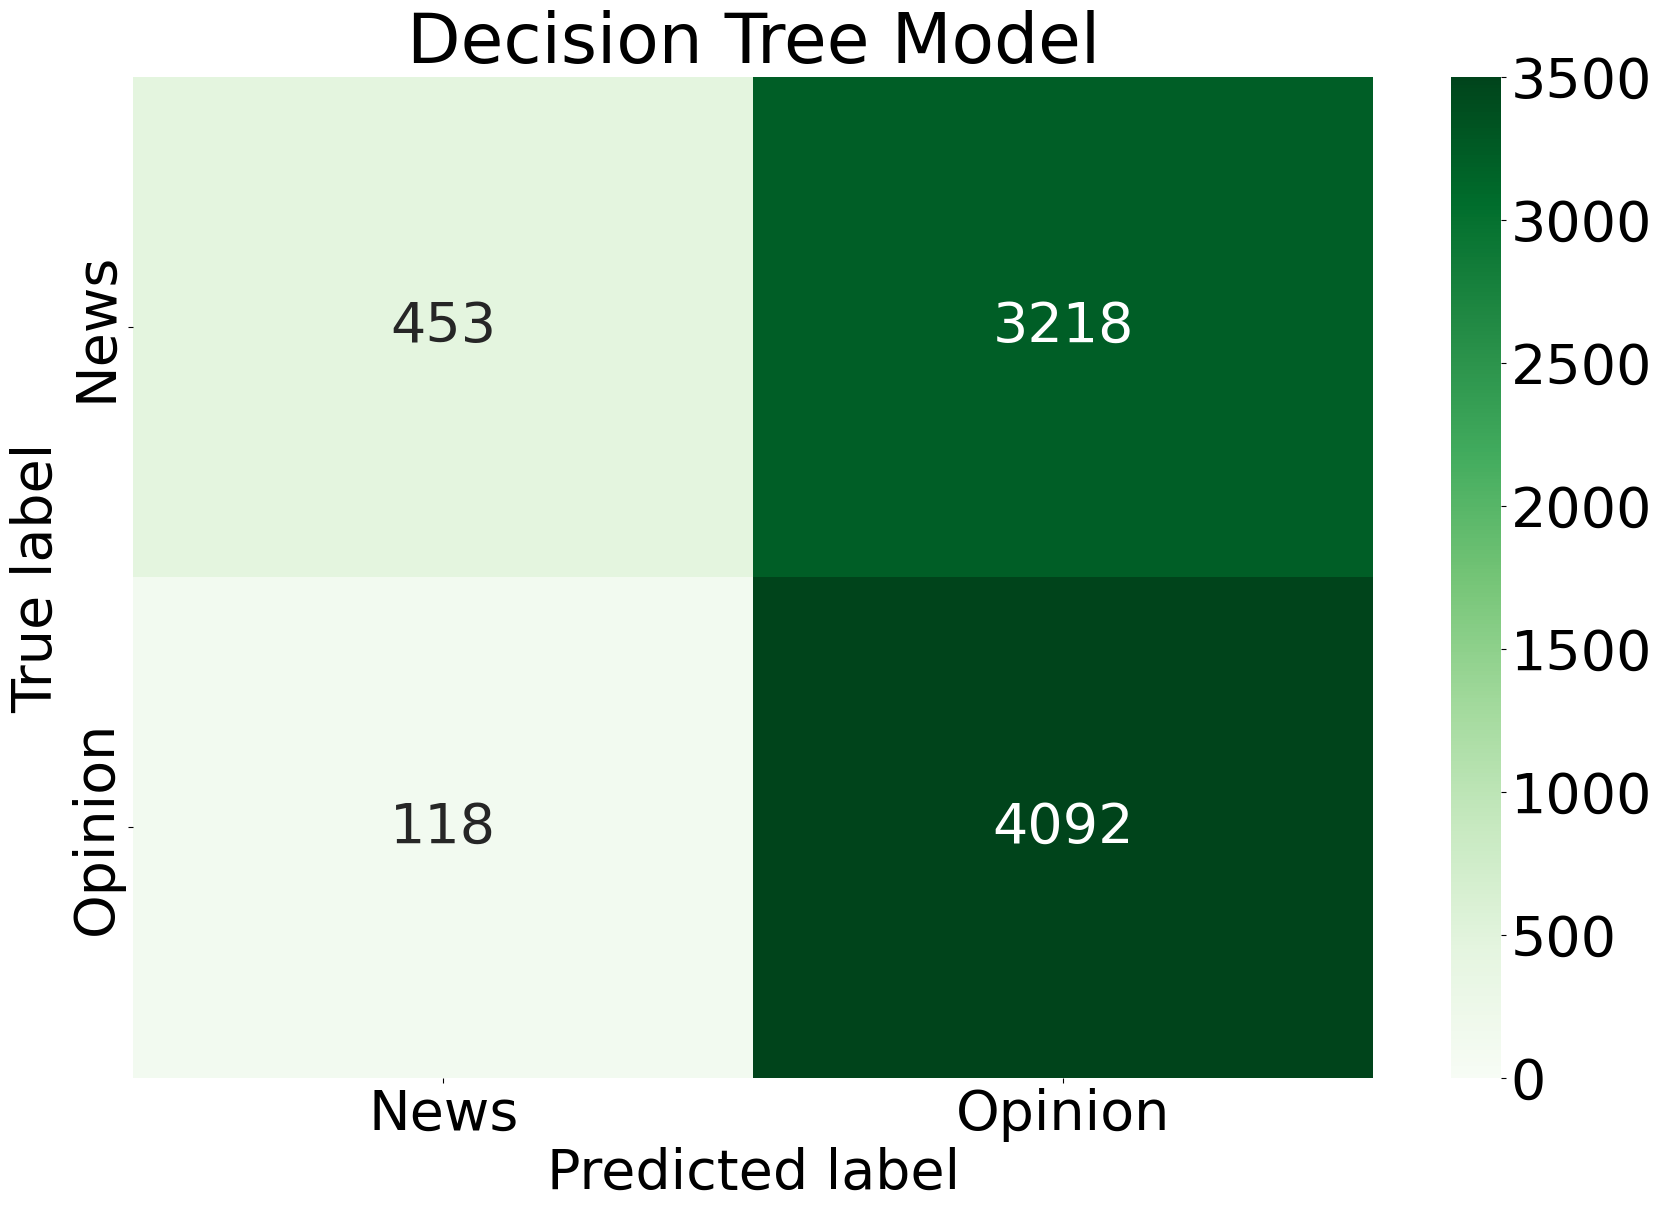

In [80]:
# Display Confusion Matrix for the test data. Remember to use the ConfusionMatrixDisplay function.

# Plot individual confusion matrices for website
plt.rcParams.update({'font.size': 40})

fig, ax = plt.subplots(figsize=(20, 13))

sns.heatmap(cm_test, annot=True, fmt='g', ax=ax, vmin=0, vmax=3500, cmap='Greens')

# Specify axis titles
ax.set_title("Decision Tree Model", fontdict={'fontsize': 50})

# Specify labels and ticks
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.xaxis.set_ticklabels(['News', 'Opinion'])
ax.yaxis.set_ticklabels(['News', 'Opinion'])

plt.savefig('./../../501-project-website/images/dt/cm.png')

There is clearly a problem with overfitting. Now we will perform hyperparameter tuning to improve model performance.

In [4]:
test_results=[]
train_results=[]

for num_layer in range(1, 20):
    model = tree.DecisionTreeClassifier(max_depth=num_layer)
    model = model.fit(bow_train, df_train['labels'])

    yp_train=model.predict(bow_train)
    yp_test=model.predict(bow_test)

    # print(y_pred.shape)
    test_results.append([num_layer,accuracy_score(df_test['labels'], yp_test),recall_score(df_test['labels'], yp_test,pos_label='news'),recall_score(df_test['labels'], yp_test,pos_label='op')])
    train_results.append([num_layer,accuracy_score(df_train['labels'], yp_train),recall_score(df_train['labels'], yp_train,pos_label='news'),recall_score(df_train['labels'], yp_train,pos_label='op')])


test_results_df = pd.DataFrame(test_results, columns=['depth', 'accuracy', 'recall_0', 'recall_1']).set_index('depth')
train_results_df = pd.DataFrame(train_results, columns=['depth', 'accuracy', 'recall_0', 'recall_1']).set_index('depth')

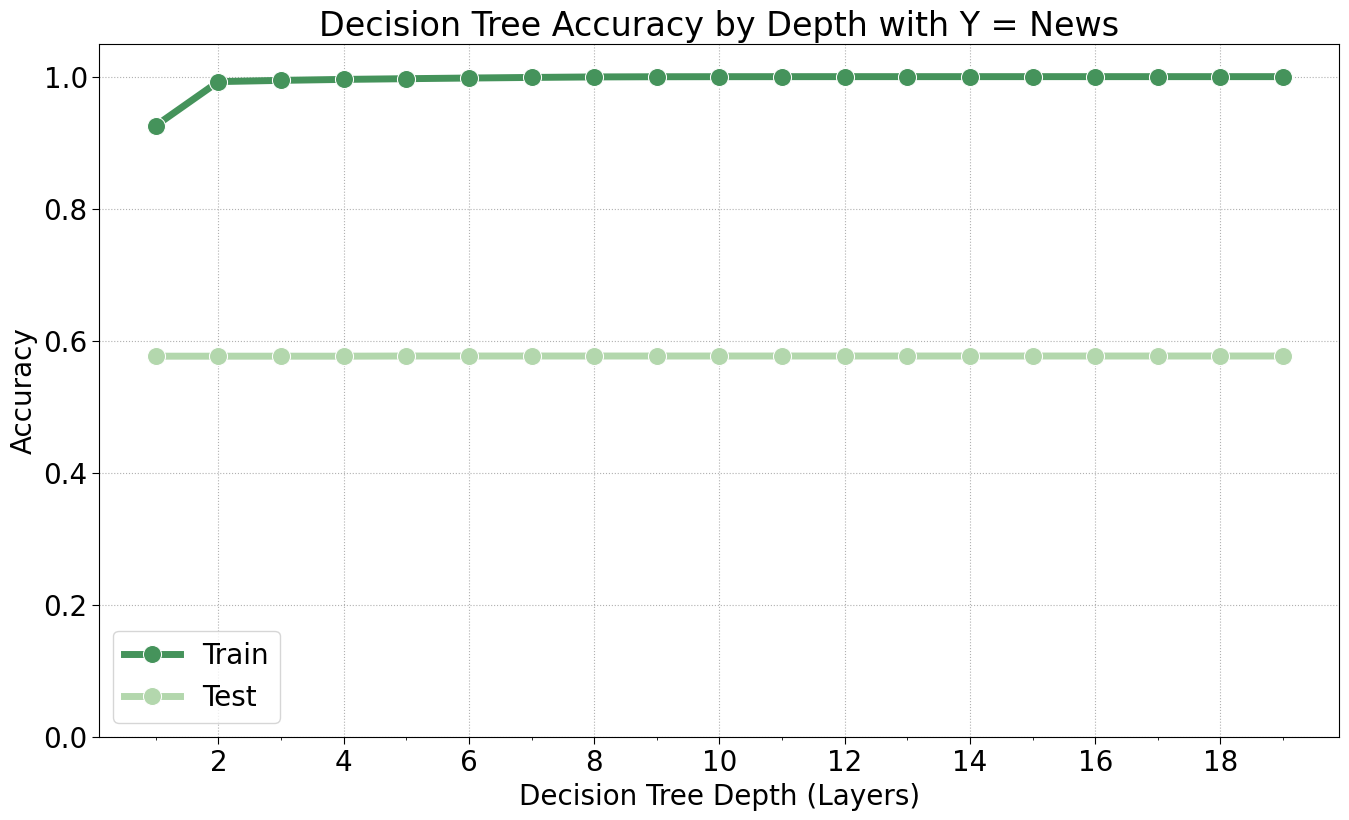

In [27]:
from matplotlib.ticker import MultipleLocator

plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [16,9]

# ACCURACY
fig1, ax1 = plt.subplots()

sns.lineplot(x=train_results_df.index, y=train_results_df['accuracy'], color='#45935B', linewidth=5, marker='o', markersize=13, label="Train", ax=ax1)
sns.lineplot(x=test_results_df.index, y=test_results_df['accuracy'], color='#B3D7AD', linewidth=5, marker='o', markersize=13, label="Test", ax=ax1)

ax1.set_xlabel('Decision Tree Depth (Layers)')
ax1.set_ylabel("Accuracy")
ax1.set_title("Decision Tree Accuracy by Depth with Y = News", fontsize=24)

# Set y limits
ax1.set_ylim(0, 1.05)

# Adjust tick behavior
ax1.xaxis.set_major_locator(MultipleLocator(2))
ax1.xaxis.set_minor_locator(MultipleLocator(1))

ax1.tick_params(which='minor', length=2)
ax1.tick_params(which='major', length=5)

ax1.grid(True, linestyle=':')

ax1.legend()

plt.savefig('../../501-project-website/images/dt/accuracy.png')



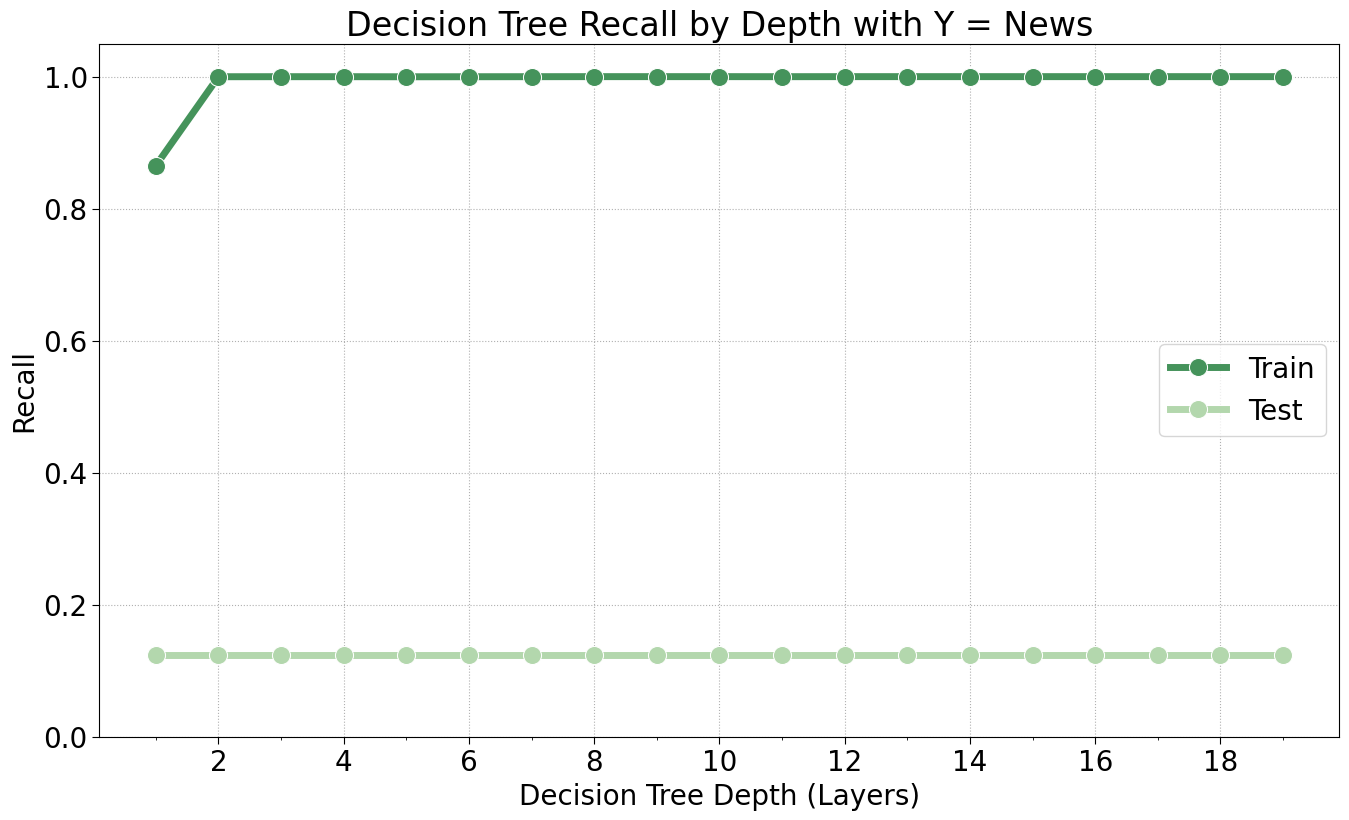

In [28]:
# RECALL Y=0
fig2, ax2 = plt.subplots()

sns.lineplot(x=train_results_df.index, y=train_results_df['recall_0'], color='#45935B', linewidth=5, marker='o', markersize=13, label="Train", ax=ax2)
sns.lineplot(x=test_results_df.index, y=test_results_df['recall_0'], color='#B3D7AD', linewidth=5, marker='o', markersize=13, label="Test", ax=ax2)

ax2.set_xlabel('Decision Tree Depth (Layers)')
ax2.set_ylabel("Recall")
ax2.set_title("Decision Tree Recall by Depth with Y = News", fontsize=24)

# Set y limits
ax2.set_ylim(0, 1.05)

# Adjust tick behavior
ax2.xaxis.set_major_locator(MultipleLocator(2))
ax2.xaxis.set_minor_locator(MultipleLocator(1))

ax2.tick_params(which='minor', length=2)
ax2.tick_params(which='major', length=5)

ax2.grid(True, linestyle=':')

ax2.legend()

plt.savefig('../../501-project-website/images/dt/recallY0.png')

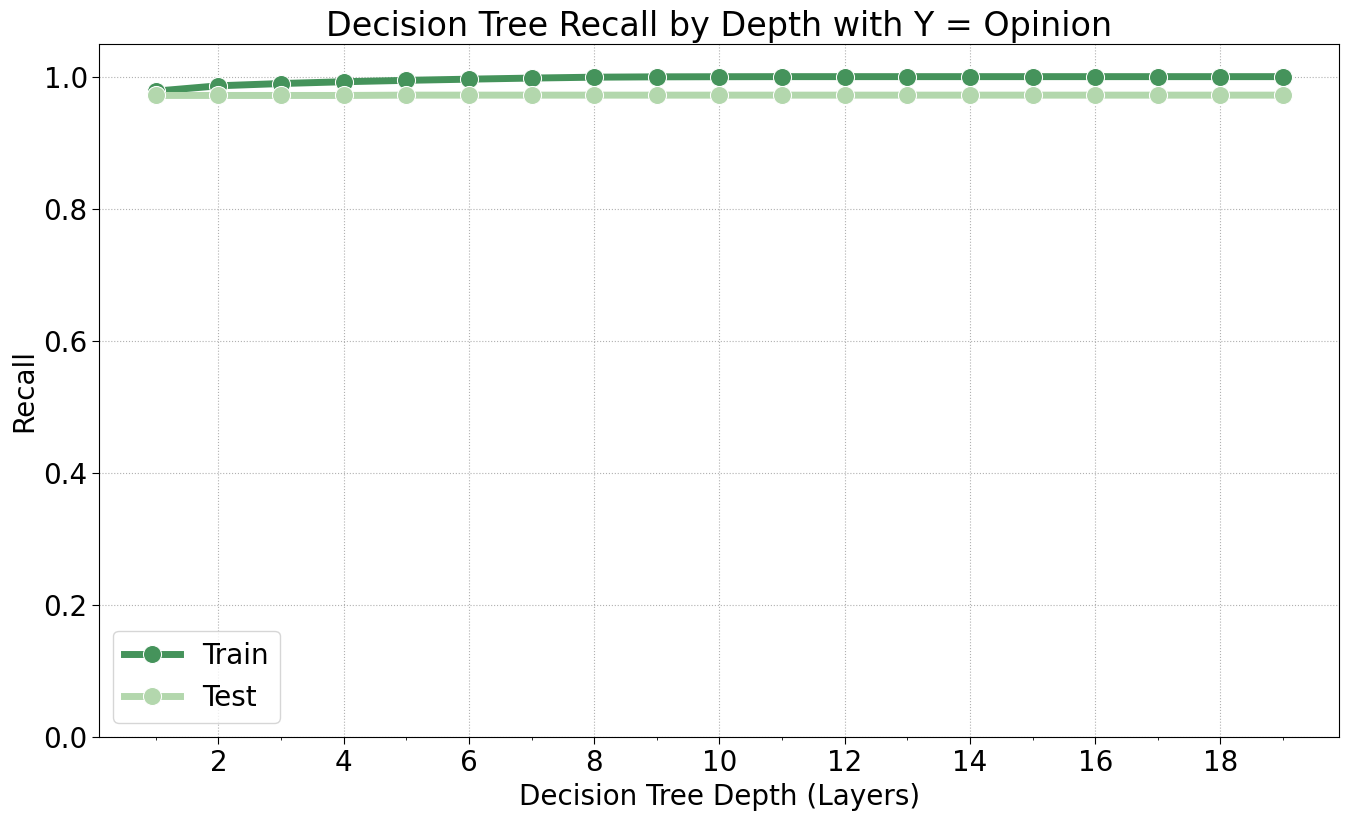

In [29]:
# RECALL Y=1
fig3, ax3 = plt.subplots()

sns.lineplot(x=train_results_df.index, y=train_results_df['recall_1'], color='#45935B', linewidth=5, marker='o', markersize=13, label="Train", ax=ax3)
sns.lineplot(x=test_results_df.index, y=test_results_df['recall_1'], color='#B3D7AD', linewidth=5, marker='o', markersize=13, label="Test", ax=ax3)

ax3.set_xlabel('Decision Tree Depth (Layers)')
ax3.set_ylabel("Recall")
ax3.set_title("Decision Tree Recall by Depth with Y = Opinion", fontsize=24)

# Set y limits
ax3.set_ylim(0, 1.05)

# Adjust tick behavior
ax3.xaxis.set_major_locator(MultipleLocator(2))
ax3.xaxis.set_minor_locator(MultipleLocator(1))

ax3.tick_params(which='minor', length=2)
ax3.tick_params(which='major', length=5)

ax3.grid(True, linestyle=':')

ax3.legend()

plt.savefig('../../501-project-website/images/dt/recallY1.png')


The maximum tree depth, surprisingly, does not affect the performance of the model on the test set.